In [ ]:
#| include: false
#all_slow

In [ ]:
#| include: false
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/11_resnet18-UNET.ipynb)

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.all import *

import cv2
import fastai
import torch
import numpy as np
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import albumentations as alb
import segmentation_models_pytorch as smp

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); device

device(type='cuda')

In [ ]:
fastai.__version__, torch.__version__

('2.3.0', '1.7.1+cu101')

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Thu Apr 29 08:24:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   29C    P8    12W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#| include: false
seed_everything()

## Data

In [ ]:
cond = train_pivot[0] != -1 # no common hard negatives
df = train_pivot.loc[cond]
df.shape

(6666, 6)

In [ ]:
def get_train_aug(height, width, with_gray=False): 
    #alb.CropNonEmptyMaskIfExists(height, width, p=0.5), #added after stage-1
    first_step = alb.RandomCrop(height, width, p=1.0)
    
    second_step = alb.OneOf([alb.VerticalFlip(p=0.5),
                              alb.HorizontalFlip(p=0.5)
                             ], p=0.5)
    
    third_step = alb.OneOf([
        alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), 
                                     contrast_limit=(-0.2, 0.2), 
                                     brightness_by_max=True,
                                     p=0.5),
        alb.RandomGridShuffle(always_apply=False, p=0.2, grid=(1, 2))], p=0.5)
    
    # to do: try with grayscale imgs
    gray_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step, second_step, third_step] + ([gray_step] if with_gray else []))

def get_valid_aug(height, width, with_gray=False): 
    first_step = alb.RandomCrop(height, width)
    gray_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step] + ([gray_step] if with_gray else []))

In [ ]:
size = (224,1568)
# size = (128,896)

In [ ]:
train_tfm = get_train_aug(*size)
valid_tfm = get_valid_aug(*size)

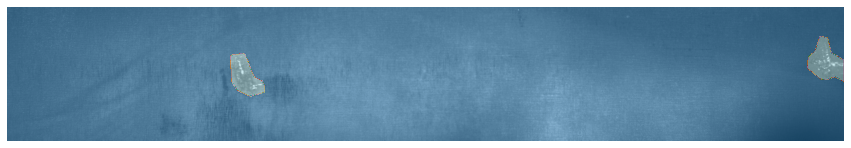

In [ ]:
block = DataBlock(blocks = (ImageBlock,SteelMaskBlock(codes=[1,2,3,4])),
                  get_x = ReadImagePathFromIndex,
                  get_y = ReadRLEs(cols=[1,2,3,4]),
                  splitter = TrainTestSplitter(test_size=0.2),
                  item_tfms=[AlbumentationsTransform(train_tfm, valid_tfm)],
                  batch_tfms=[Normalize.from_stats(*imagenet_stats)])

ds = block.datasets(df)

img, mask = ds.valid[1]
ax = img.show(figsize=(15,5))
mask.show(ctx=ax);

## SMP - Training

In [ ]:
dls = block.dataloaders(source=df, 
                        bs=8, 
                        device=device, 
                        num_workers=0)

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([8, 3, 224, 1568]), torch.Size([8, 4, 224, 1568]))

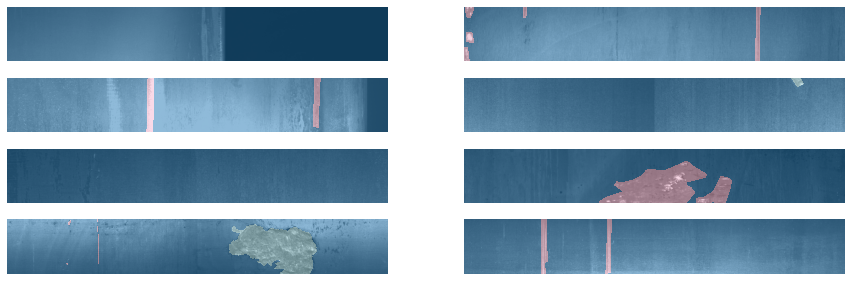

In [ ]:
dls.show_batch(ncols=2, figsize=(15,5))

In [ ]:
arch = smp.Unet('resnet18', classes=4, activation=None, 
                encoder_weights='imagenet',
                decoder_attention_type='scse')

![UNET Architecture](../imgs/unet.png)

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(params, torch.optim.Adam, **kwargs)
def splitter(m): return convert_params([[m.encoder], [m.decoder], [m.segmentation_head]])

In [ ]:
learn = Learner(dls=dls, 
                model=arch, 
                loss_func=BCEWithLogitsLossFlat(axis=1),
                metrics=[ModDiceMulti(with_logits=True)], 
                         #KaggleDice(with_logits=True)], 
                splitter=splitter, 
                opt_func=opt_func, 
                model_dir=models_dir, 
                cbs=[CudaCallback(), ShowGraphCallback()]).to_fp16()

Checking that is all right and freezed up to the encoder part of the network.

In [ ]:
#learn.freeze_to(-2)
learn.unfreeze()

In [ ]:
learn.summary()

Unet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 784  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                             

Due to misconception I previously trained the model without augmentations in the following stage.

In [ ]:
stage = "resnet18-UNET-stage0"

In [ ]:
fit_cbs = [
    GradientAccumulation(n_acc=16),
    ReduceLROnPlateau(monitor='valid_loss', patience=2),
    CSVLogger(fname=f'{models_dir}/logs/{stage}.csv'),
    SaveModelCallback(monitor='valid_loss', fname=stage)]

epoch,train_loss,valid_loss,mod_dice_multi,kaggle_dice,time
0,0.331490,0.243579,0.334487,0.992355,03:50
1,0.153554,0.095864,0.374777,0.993230,03:34
2,0.082336,0.054789,0.405541,0.993442,03:34
3,0.056787,0.045147,0.394832,0.995075,03:34
4,0.043801,0.034790,0.499148,0.995216,03:34


Better model found at epoch 0 with valid_loss value: 0.24357937276363373.


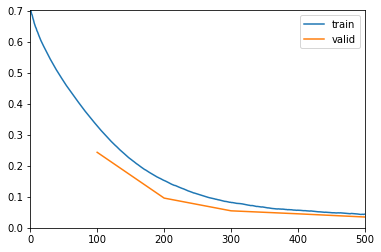

Better model found at epoch 1 with valid_loss value: 0.09586432576179504.
Better model found at epoch 2 with valid_loss value: 0.05478934943675995.
Better model found at epoch 3 with valid_loss value: 0.045146528631448746.
Better model found at epoch 4 with valid_loss value: 0.03479013219475746.


In [ ]:
#test
learn.dls = block.dataloaders(df.iloc[:1000], bs=8, num_workers=0)
learn.fit(5, lr=4e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,mod_dice_multi,time
0,0.023497,0.025300,0.606599,23:05
1,0.022876,0.021966,0.613161,22:34
2,0.024106,0.026706,0.495589,22:33
3,0.022126,0.025351,0.567934,22:34
4,0.021223,0.021900,0.611003,22:33
5,0.019121,0.021640,0.605284,22:32
6,0.017413,0.018976,0.619135,22:32
7,0.015116,0.019578,0.629206,22:39
8,0.013478,0.018224,0.630105,22:33
9,0.013250,0.018327,0.634405,22:30


Better model found at epoch 0 with valid_loss value: 0.02530030533671379.


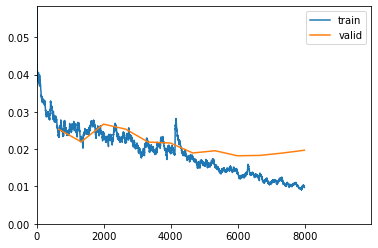

Better model found at epoch 1 with valid_loss value: 0.021966340020298958.
Better model found at epoch 4 with valid_loss value: 0.021900275722146034.
Better model found at epoch 5 with valid_loss value: 0.021639974787831306.
Better model found at epoch 6 with valid_loss value: 0.018975717946887016.
Better model found at epoch 8 with valid_loss value: 0.018224189057946205.


In [ ]:
learn.fit_one_cycle(15, lr_max=5e-4, div=5., cbs=fit_cbs)

In [ ]:
loaded_learn = learn.load(stage)

In [ ]:
loaded_learn.validate()

(#2) [0.019153397530317307,0.62952175137253]

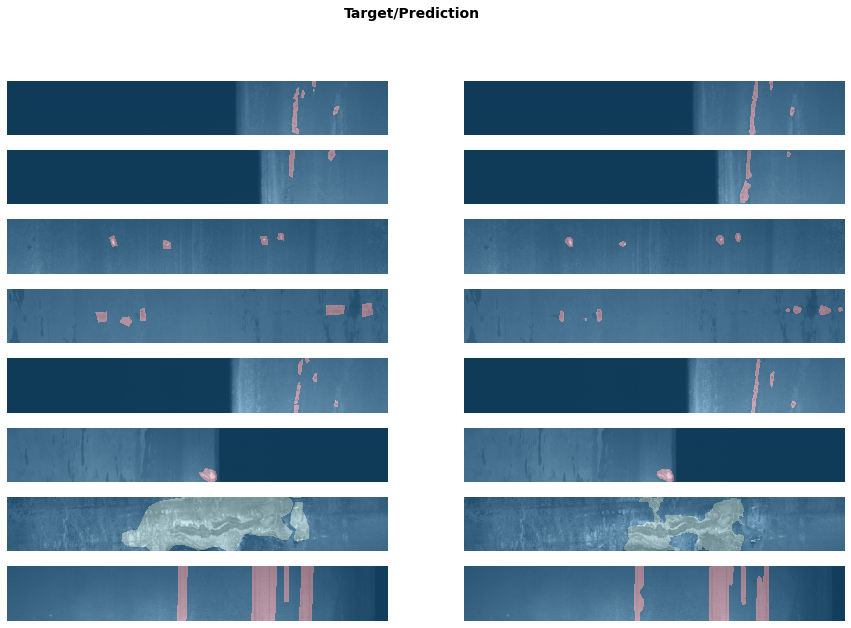

In [ ]:
loaded_learn.show_results(figsize=(15,10))

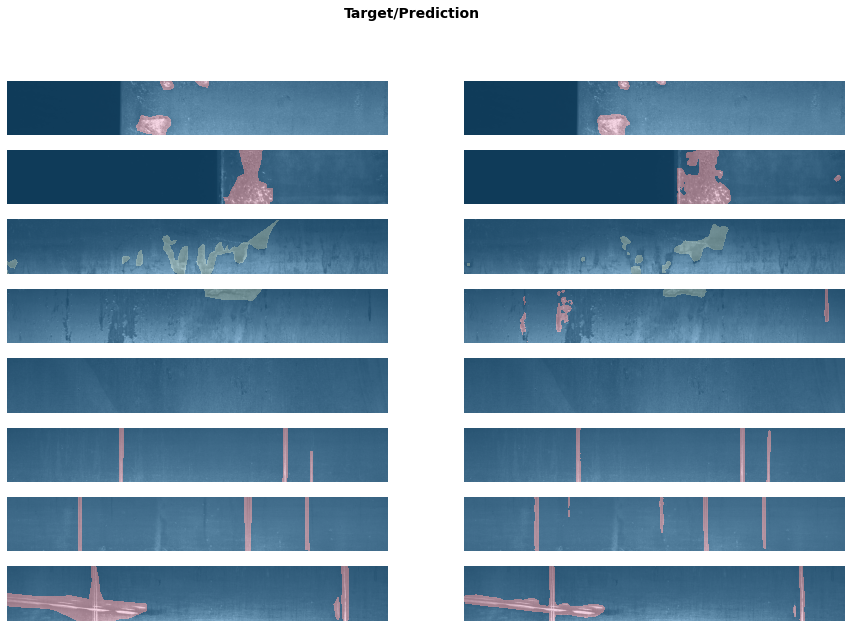

In [ ]:
loaded_learn.show_results(figsize=(15,10))

In [ ]:
# to load the weights use
arch.load_state_dict(torch.load(models_dir/("resnet18-UNET-stage0.pth")))

<All keys matched successfully>